In [43]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import pickle
import re
import emoji

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.models import load_model

import torch
from torch.utils.data import DataLoader, Dataset

from transformers import TrainingArguments, Trainer, AutoTokenizer, AutoModelForSequenceClassification


# Load the Data

In [2]:
train_df = pd.read_csv("/kaggle/input/twitter-entity-sentiment-analysis/twitter_training.csv", header=None)
val_df = pd.read_csv("/kaggle/input/twitter-entity-sentiment-analysis/twitter_validation.csv", header=None)

In [3]:
print("Training shape:", train_df.shape)
print("Validation shape:", val_df.shape)

Training shape: (74682, 4)
Validation shape: (1000, 4)


In [4]:
train_df.head()

,0,1,2,3
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
3,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
4,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...


In [5]:
val_df.head()

,0,1,2,3
0,3364,Facebook,Irrelevant,I mentioned on Facebook that I was struggling ...
1,352,Amazon,Neutral,BBC News - Amazon boss Jeff Bezos rejects clai...
2,8312,Microsoft,Negative,@Microsoft Why do I pay for WORD when it funct...
3,4371,CS-GO,Negative,"CSGO matchmaking is so full of closet hacking,..."
4,4433,Google,Neutral,Now the President is slapping Americans in the...


In [6]:
train_df.columns = ['tweet_id', 'entity', 'sentiment', 'content']
val_df.columns = ['tweet_id', 'entity', 'sentiment', 'content']

In [7]:
train_df.columns

Index(['tweet_id', 'entity', 'sentiment', 'content'], dtype='object')

# Remove duplicates and nulls

In [8]:
train_df.duplicated().sum()

2700

In [9]:
train_df = train_df.drop_duplicates().reset_index(drop=True)

In [10]:
train_df.isna().sum()

tweet_id       0
entity         0
sentiment      0
content      326
dtype: int64

In [11]:
train_df[train_df['content'].isna()]

,tweet_id,entity,sentiment,content
58,2411,Borderlands,Neutral,NaN
536,2496,Borderlands,Neutral,NaN
572,2503,Borderlands,Neutral,NaN
722,2532,Borderlands,Positive,NaN
1071,2595,Borderlands,Positive,NaN
...,...,...,...,...
71004,9019,Nvidia,Positive,NaN
71103,9036,Nvidia,Negative,NaN
71190,9053,Nvidia,Positive,NaN
71297,9073,Nvidia,Positive,NaN


In [12]:
train_df = train_df.dropna().reset_index(drop=True)

# Preprocess text

In [13]:
def preprocess_text(text):
    text = str(text).lower()                                # lowercase
    text = re.sub(r"http\S+|www\S+|https\S+", '', text)     # remove urls
    text = re.sub(r"@\w+|#\w+", '', text)                   # remove mentions & hashtags
    text = re.sub(r"[0-9]+", '', text)                      # remove numbers
    text = re.sub(r"[^\w\s]", '', text)                     # remove punctuation
    text = emoji.replace_emoji(text, replace='')            # remove emojis
    text = re.sub(r"\s+", ' ', text).strip()                # remove extra spaces
    return text

In [14]:
train_df['content'] = train_df['content'].apply(preprocess_text)
val_df['content']   = val_df['content'].apply(preprocess_text)

In [15]:
train_df.head()

,tweet_id,entity,sentiment,content
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...
1,2401,Borderlands,Positive,i am coming to the borders and i will kill you...
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you all
3,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
4,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...


# Encode labels

In [16]:
label_encoder = LabelEncoder()
train_df['sentiment'] = label_encoder.fit_transform(train_df['sentiment'])
val_df['sentiment'] = label_encoder.transform(val_df['sentiment'])

So the mapping is:

Irrelevant → 0

Negative → 1

Neutral → 2

Positive → 3

In [44]:
# Save Label Encoder
with open("label_encoder.pkl", "wb") as f:
    pickle.dump(label_encoder, f)

# TF-IDF Vectorization

In [17]:
tfidf = TfidfVectorizer(max_features=5000)
x_train_tfidf = tfidf.fit_transform(train_df['content']).toarray()
x_val_tfidf = tfidf.transform(val_df['content']).toarray()

**Result: a 2D numpy array with shape (num_samples_train, 5000)**

**TF-IDF weights words by importance:**


* Common words like “the”, “is” → low weight
* Rare but meaningful words like “amazing”, “disappointed” → high weight


**Makes LSTM/ML models learn signal words for sentiment rather than raw frequency.**

In [45]:
# Save TF-IDF vectorizer
with open("tfidf_vectorizer.pkl", "wb") as f:
    pickle.dump(tfidf, f)

In [18]:
y_train = train_df['sentiment'].values
y_val = val_df['sentiment'].values

# Reshape for LSTM


**LSTM expects 3D input: (samples, timesteps, features).**

**Here, each TF-IDF vector is treated as one timestep with features.**


In [19]:
x_train_lstm = np.expand_dims(x_train_tfidf, axis=1)
x_val_lstm = np.expand_dims(x_val_tfidf, axis=1)

**Adds an extra dimension at position 1 → now shape: (num_samples_train, 1, 5000)**

samples → number of tweets

timesteps → number of time steps (here 1, because TF-IDF is a single vector per tweet)

features → size of feature vector (5000)

# LSTM

In [20]:
num_classes = len(label_encoder.classes_)

lstm_model = Sequential()
lstm_model.add(LSTM(128, input_shape=(x_train_lstm.shape[1], x_train_lstm.shape[2])))
lstm_model.add(Dropout(0.5))
lstm_model.add(Dense(num_classes, activation='softmax'))

I0000 00:00:1759569549.900343      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1759569549.901049      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [21]:
lstm_model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [22]:
early_stop = EarlyStopping(
    monitor='val_loss', 
    patience=5, 
    restore_best_weights=True
)

model_checkpoint = ModelCheckpoint(
    'best_lstm_model.h5',
    monitor='val_loss',
    save_best_only=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.5, 
    patience=2, 
    min_lr=1e-5
)

In [23]:
history = lstm_model.fit(
    x_train_lstm, y_train,
    validation_data=(x_val_lstm, y_val),
    epochs=100,    
    batch_size=64,
    callbacks=[early_stop, model_checkpoint, reduce_lr]
)

Epoch 1/100


I0000 00:00:1759569557.863091      98 cuda_dnn.cc:529] Loaded cuDNN version 90300


1120/1120 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.4978 - loss: 1.1672 - val_accuracy: 0.7680 - val_loss: 0.6344 - learning_rate: 0.0010
Epoch 2/100
1120/1120 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.7094 - loss: 0.7464 - val_accuracy: 0.8290 - val_loss: 0.5197 - learning_rate: 0.0010
Epoch 3/100
1120/1120 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.7439 - loss: 0.6578 - val_accuracy: 0.8440 - val_loss: 0.4802 - learning_rate: 0.0010
Epoch 4/100
1120/1120 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.7564 - loss: 0.6284 - val_accuracy: 0.8540 - val_loss: 0.4540 - learning_rate: 0.0010
Epoch 5/100
1120/1120 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.7665 - loss: 0.6025 - val_accuracy: 0.8680 - val_loss: 0.4270 - learning_rate: 0.0010
Epoch 6/100
1120/1120 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.7779 - loss: 0.5746 - val_accuracy: 0.8740 - val_loss: 0.4060 - learning_rate: 0.0010
Epoch 7/100
1120/1120 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.7868 - loss:

# LSTM Evaluation

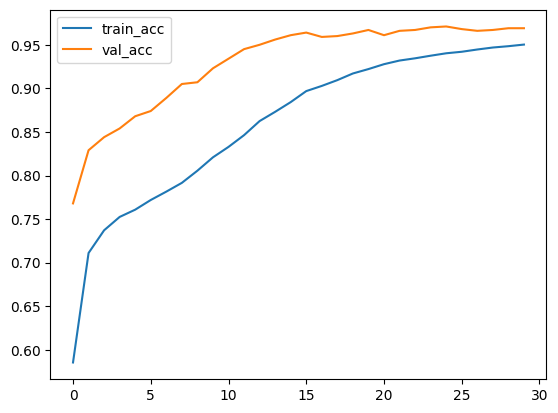

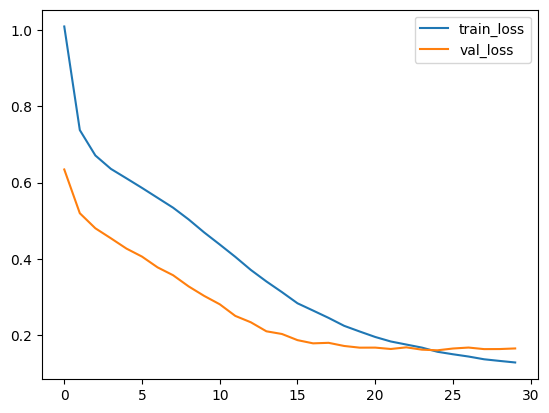

In [24]:
plt.plot(history.history['accuracy'], label='train_acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

In [25]:
best_lstm_model = load_model('best_lstm_model.h5')

In [26]:
y_pred = best_lstm_model.predict(x_val_lstm)
y_pred_classes = np.argmax(y_pred, axis=1)

print(classification_report(y_val, y_pred_classes, target_names=label_encoder.classes_))

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
              precision    recall  f1-score   support

  Irrelevant       0.97      0.98      0.97       172
    Negative       0.99      0.97      0.98       266
     Neutral       0.97      0.96      0.97       285
    Positive       0.95      0.98      0.97       277

    accuracy                           0.97      1000
   macro avg       0.97      0.97      0.97      1000
weighted avg       0.97      0.97      0.97      1000



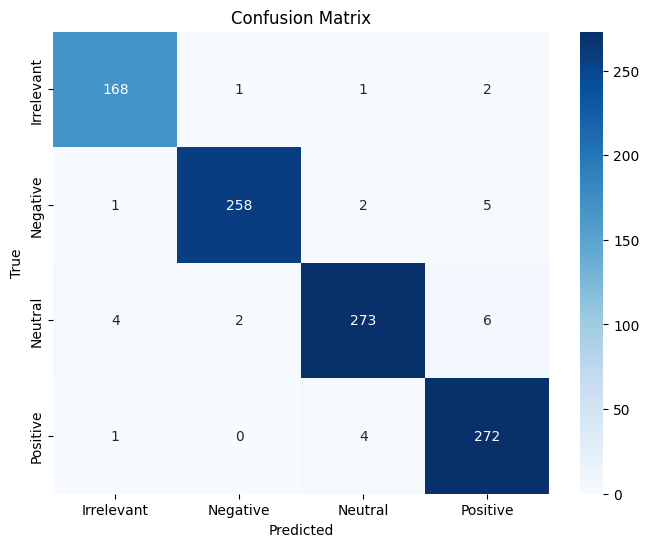

In [27]:
conf_matrix = confusion_matrix(y_val, y_pred_classes)
plt.figure(figsize=(8,6))
sns.heatmap(
    conf_matrix,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=label_encoder.classes_,
    yticklabels=label_encoder.classes_
)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Test LSTM with new Texts

In [28]:
texts = [
    "I love this product!",    # positive
    "This is terrible."       # negative
]

In [29]:
x_input = tfidf.transform(texts).toarray()
x_input = np.expand_dims(x_input, axis=1)

In [30]:
y_pred_probs = best_lstm_model.predict(x_input)
y_pred_classes = np.argmax(y_pred_probs, axis=1)
predicted_labels = label_encoder.inverse_transform(y_pred_classes)

print(predicted_labels)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
['Irrelevant' 'Negative']


# BERT

In [31]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

# Tokenization
x_train_bert = tokenizer(list(train_df['content']), truncation=True, padding=True, max_length=128)
x_val_bert = tokenizer(list(val_df['content']), truncation=True, padding=True, max_length=128)


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

# Create Dataset

In [32]:
class SentimentDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

train_ds = SentimentDataset(x_train_bert, y_train)
val_ds = SentimentDataset(x_val_bert, y_val)


In [33]:
bert_model = AutoModelForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=num_classes)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [34]:
def compute_metrics(p):
    preds = p.predictions.argmax(-1)
    labels = p.label_ids
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')
    acc = accuracy_score(labels, preds)
    return {'accuracy': acc, 'f1': f1, 'precision': precision, 'recall': recall}

# BERT Training

In [35]:
training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    logging_steps=10, 
    weight_decay=0.01,
    logging_dir="./logs",
    report_to="none"
)

In [36]:
trainer = Trainer(
    model=bert_model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

/tmp/ipykernel_36/350591233.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [37]:
trainer.train()

/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.750600,0.339767,0.895000,0.895160,0.896097,0.895000
2,0.406600,0.120638,0.964000,0.963971,0.964138,0.964000
3,0.241000,0.098865,0.976000,0.976008,0.976067,0.976000


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


TrainOutput(global_step=6720, training_loss=0.4973680467477867, metrics={'train_runtime': 3026.6204, 'train_samples_per_second': 71.026, 'train_steps_per_second': 2.22, 'total_flos': 1.4140368253919232e+16, 'train_loss': 0.4973680467477867, 'epoch': 3.0})

# BERT Evaluation

In [38]:
results = trainer.evaluate()
print(results)

/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


{'eval_loss': 0.09886492788791656, 'eval_accuracy': 0.976, 'eval_f1': 0.9760080487771765, 'eval_precision': 0.9760665701065168, 'eval_recall': 0.976, 'eval_runtime': 3.2737, 'eval_samples_per_second': 305.461, 'eval_steps_per_second': 9.775, 'epoch': 3.0}


In [39]:
trainer.save_model("./bert_model")